In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import random
from scipy.stats import chi2


## Load and clean data ##

data = pd.read_csv(r'/GlobalLandTemperaturesByCountry.csv')
temp_df = pd.DataFrame(data, columns=['AverageTemperature'])

temp_df = temp_df.dropna(
    axis=0,
    how='any'
)

temp_df['rounded'] = temp_df.AverageTemperature.round(decimals=0)
temp_df['rounded'] = temp_df['rounded'].astype(int) #float to int
print(temp_df)

      AverageTemperature  rounded
0                 26.422       26
1                 29.377       29
2                 29.547       30
3                 30.012       30
4                 27.094       27
...                  ...      ...
2663              23.915       24
2664              29.503       30
2665              30.337       30
2666              30.553       31
2667              29.866       30

[2666 rows x 2 columns]


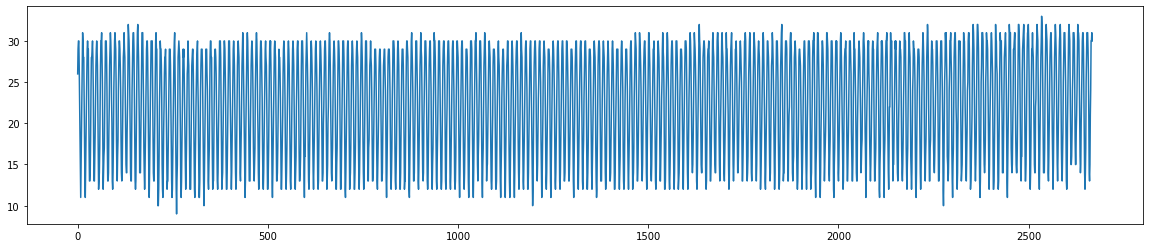

In [ ]:
## Plot state frequencies ##

temp_df.rounded.plot(figsize=(20,4))

In [ ]:
## Combine states into buckets ##
temp_df['binned_states'] = pd.cut(x=temp_df.rounded, bins=13, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12], ordered=False)
states = temp_df.binned_states
print(states)


0        9
1       10
2       11
3       11
4        9
        ..
2663     8
2664    11
2665    11
2666    11
2667    11
Name: binned_states, Length: 2666, dtype: category
Categories (13, int64): [0, 1, 2, 3, ..., 9, 10, 11, 12]


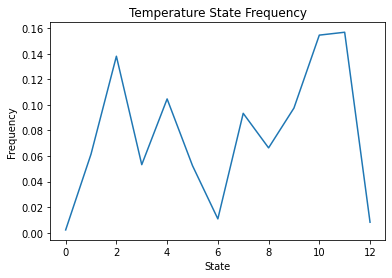

In [ ]:
## Step 5: Occupation Frequencies ##

x, y = np.unique(temp_df['binned_states'], return_counts=True)
plt.plot(x, y/sum(y))
plt.title("Temperature State Frequency")
plt.xlabel("State")
plt.ylabel("Frequency")
plt.show()

In [ ]:
## Step 6: Jumps between each state ##

def transition_matrix(state_list):
    n = 1+ max(state_list) #number of states

    M = np.zeros((n,n))

    for (i,j) in zip(state_list,state_list[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
          row[:] = [f/s for f in row]
    return M


states_list = states.values.tolist()

matrix = transition_matrix(states_list)
P_ij = np.around(matrix, 5)
print(f"P_ij matrix:\n\n {P_ij}")



P_ij matrix:

 [[0.16667 0.33333 0.5     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.0122  0.15854 0.57317 0.23171 0.02439 0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.00543 0.24457 0.2663  0.16033 0.24185 0.07609 0.      0.00272 0.00272
  0.      0.      0.      0.     ]
 [0.      0.08451 0.15493 0.06338 0.28873 0.30282 0.02113 0.07746 0.
  0.00704 0.      0.      0.     ]
 [0.00358 0.10753 0.37276 0.02509 0.01075 0.00358 0.06452 0.34409 0.0681
  0.      0.      0.      0.     ]
 [0.      0.02857 0.31429 0.14286 0.      0.      0.00714 0.38571 0.12143
  0.      0.      0.      0.     ]
 [0.      0.      0.10345 0.10345 0.03448 0.      0.      0.03448 0.2069
  0.48276 0.03448 0.      0.     ]
 [0.      0.      0.      0.01606 0.26908 0.05221 0.      0.00803 0.03213
  0.51004 0.10843 0.00402 0.     ]
 [0.      0.      0.      0.0113  0.39548 0.28249 0.0113  0.00565 0.00565
  0.10169 0.16384 0.0226  0.     ]
 [0.      0.      0. 

In [ ]:
## Step 7: Find the stationary distribution ##

stationary_matrix = np.linalg.matrix_power(matrix, 13)
## all entries are positive, so it is regular so all vectors will converge to stationary


stationary_matrix = np.linalg.matrix_power(matrix, 50)
stationary_vector = stationary_matrix[1].round(4)
# vector is unique
print(f"stationary vector for P_ij:\n\n{stationary_vector}")

stationary vector for P_ij:

[0.0023 0.0615 0.138  0.0533 0.1046 0.0525 0.0109 0.0933 0.0664 0.0972
 0.1547 0.1571 0.0083]


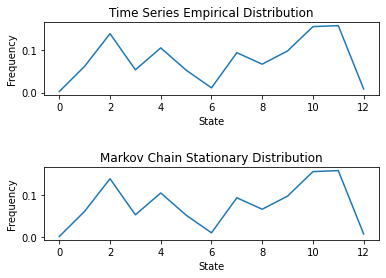

In [ ]:
## Step 8: compare empirical distribution of data and the stationary distribution ##
fig, (emp, stat) = plt.subplots(nrows = 2, ncols = 1)
fig.subplots_adjust(hspace = 1.0)

# Time series data
x1, y1 = np.unique(temp_df['binned_states'], return_counts=True)
emp.plot(x1, y1/sum(y1))
emp.set_title("Time Series Empirical Distribution")
emp.set_xlabel("State")
emp.set_ylabel("Frequency")

# Stationary distribution
x2, y2 = np.unique(temp_df['binned_states'], return_counts=True)
stat.plot(x2, stationary_vector)
stat.set_title("Markov Chain Stationary Distribution")
stat.set_xlabel("State")
stat.set_ylabel("Frequency")

plt.show()

In [ ]:
## Step 9: simulation ##

n = len(states_list)
xk = np.arange(len(matrix))
sim = np.zeros(n)
#start at state 9
sim[0] = 2

def generate_sample(cur_state):
    p = matrix[:, cur_state]
    p /= p.sum()
    return np.random.choice(xk, 1,  p=p)



for i in range(1, n):
    sim[i] = generate_sample(int(sim[i-1]))[0]


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:350: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


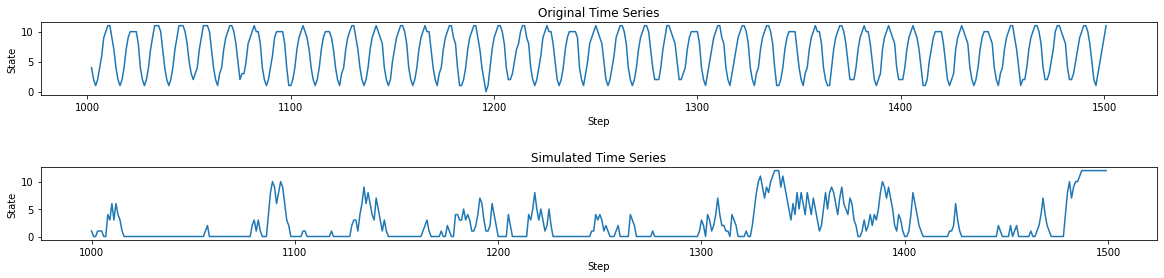

In [ ]:
fig, (orig, simulation) = plt.subplots(nrows = 2, ncols = 1, figsize=(20,4))
fig.subplots_adjust(hspace = 1.0)

sim_df = pd.DataFrame(sim)

# Time series data
orig.plot(states[1000:1500])
orig.set_title("Original Time Series")
orig.set_xlabel("Step")
orig.set_ylabel("State")

# Stationary distribution
simulation.plot(sim_df[1000:1500])
simulation.set_title("Simulated Time Series")
simulation.set_xlabel("Step")
simulation.set_ylabel("State")

plt.show()

In [ ]:
## Two Step Count Matrix ##

def two_step_count(state_list):
  n = 1+ max(state_list) #number of states

  N = np.zeros((n,n))

  for (i,j) in zip(state_list,state_list[2:]):
      N[i][j] += 1

  return N

# create matrix
N_ij = two_step_count(states.values.to_list())
print(f"N_ij matrix:\n\n{N_ij}\n\n")

st_list = states.values.to_list()

#validate it is working!
count = 0
for k, v in enumerate(st_list):
  if v == 12 and st_list[k+2] == 11:
    count += 1


#Find Ni from Nij
#for i in two_step_matrix:
N_i = list(N_ij.sum(axis=1))
print(f"Summation of rows, N_i:\n\n{N_i}\n\n")

#Ni x Pij^2
P2_ij = np.linalg.matrix_power(P_ij, 2)
unique_states = list(set(states))
M_ij = np.zeros((13,13))
for i in unique_states:
  M_ij[i] = np.around(np.multiply(P2_ij[i], N_i[i]), 5)
np.set_printoptions(suppress=True)
print(f"M_ij matrix:\n\n{M_ij}\n\n")

# Chi Square Test
d = 0
for k, i in enumerate(N_ij):
  for l, j in enumerate(N_ij[k]):
    if M_ij[k][l] != 0:
      d += ((j - M_ij[k][l])**2)/(M_ij[k][l])

print(f"d value: {d}\n\n")

m = len(unique_states)
df = m**2 - m

critical_value= chi2.ppf(q = 0.95, df = 156)
print(f"X^2 critical value: {critical_value}")

N_ij matrix:

[[  0.   1.   0.   2.   2.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.  27.  17.  85.  28.   1.   5.   0.   0.   0.   0.   0.]
 [  0.   3.  84.  65.  49.  38.  15.  95.  18.   1.   0.   0.   0.]
 [  0.   4.  17.  15.   1.   5.   6.  60.  22.   9.   3.   0.   0.]
 [  4.  85.  51.   2.   0.   0.   0.   5.   8. 100.  24.   0.   0.]
 [  1.  31.  33.   3.   0.   0.   0.   0.   4.  48.  19.   1.   0.]
 [  0.   3.   3.   1.   0.   0.   0.   0.   0.   1.  16.   5.   0.]
 [  1.  19.  58.   6.   0.   0.   0.   0.   0.   2.  90.  69.   4.]
 [  0.  15.  88.  21.   1.   0.   0.   0.   0.   0.  13.  37.   2.]
 [  0.   2.   7.   7.  62.  19.   1.   0.   0.   0.  31. 129.   2.]
 [  0.   0.   0.   3.  71.  41.   4.  39.  49.  25.  90.  80.  10.]
 [  0.   0.   0.   0.   8.   8.   2.  44.  73.  72. 118.  87.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   3.   1.   7.  10.   0.]]


Summation of rows, N_i:

[6.0, 164.0, 368.0, 142.0, 279.0, 140.0, 29.0, 249.0, 177.0, 260.0, 412.0,

In [ ]:
## REDUCE OUR STATES ##

temp_df['binned_states'] = pd.cut(x=temp_df.rounded, bins=5, labels=[0,1,2,3,4], ordered=False)
states = temp_df.binned_states

states_list = states.values.tolist()


matrix = transition_matrix(states_list)
P_ij = np.around(matrix, 5)

# create matrix
N_ij = two_step_count(states.values.to_list())
print(f"N_ij matrix:\n\n{N_ij}\n\n")

st_list = states.values.to_list()

#validate it is working!
count = 0
for k, v in enumerate(st_list):
  if v == 12 and st_list[k+2] == 11:
    count += 1


#Find Ni from Nij
#for i in two_step_matrix:
N_i = list(N_ij.sum(axis=1))
print(f"Summation of rows, N_i:\n\n{N_i}\n\n")

#Ni x Pij^2
P2_ij = np.linalg.matrix_power(P_ij, 2)
unique_states = list(set(states))
M_ij = np.zeros((5,5))
for i in unique_states:
  M_ij[i] = np.around(np.multiply(P2_ij[i], N_i[i]), 5)
np.set_printoptions(suppress=True)
print(f"M_ij matrix:\n\n{M_ij}\n\n")

# Chi Square Test
d = 0
for k, i in enumerate(N_ij):
  for l, j in enumerate(N_ij[k]):
    if M_ij[k][l] != 0:
      d += ((j - M_ij[k][l])**2)/(M_ij[k][l])

print(f"d value: {d}\n\n")

m = len(unique_states)
df = m**2 - m

critical_value= chi2.ppf(q = 0.95, df = 156)
print(f"X^2 critical value: {critical_value}")

N_ij matrix:

[[ 30. 236.  98.   7.   0.]
 [152.  97. 161. 175.   3.]
 [119.  40.   0.  85. 174.]
 [ 70. 191.  54.  10. 263.]
 [  0.  24. 105. 310. 260.]]


Summation of rows, N_i:

[371.0, 588.0, 418.0, 588.0, 699.0]


M_ij matrix:

[[134.51336 156.57674  69.65686   9.85436   0.4021 ]
 [151.02511 217.52321 105.40431 105.556     8.48707]
 [ 52.8063   99.91735  98.83311  89.61132  76.83391]
 [ 32.18865  83.95904  86.85734 176.03731 208.9509 ]
 [  0.46826  29.85127  56.93758 205.69503 406.04578]]


d value: 1131.9578020400206


X^2 critical value: 186.14575078141743
